In [37]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import deque
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import  torchvision.transforms as transforms

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper

import warnings
warnings.filterwarnings('ignore')

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:1


<Axes: xlabel='step', ylabel='score'>

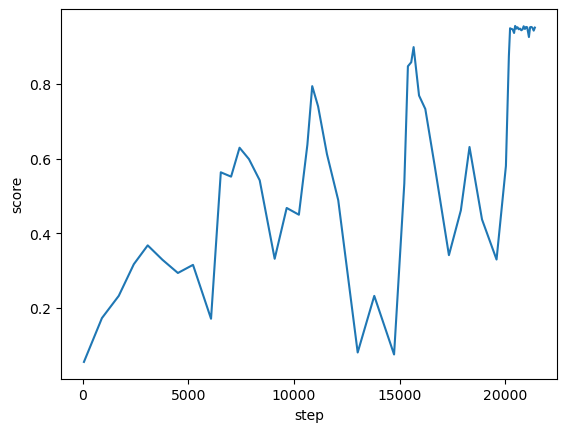

In [5]:
df = pd.read_csv('logs/Uniform-DDQN-Minigrid2.csv')
sns.lineplot(data=df, x='step',y='score')

<Axes: xlabel='step', ylabel='score'>

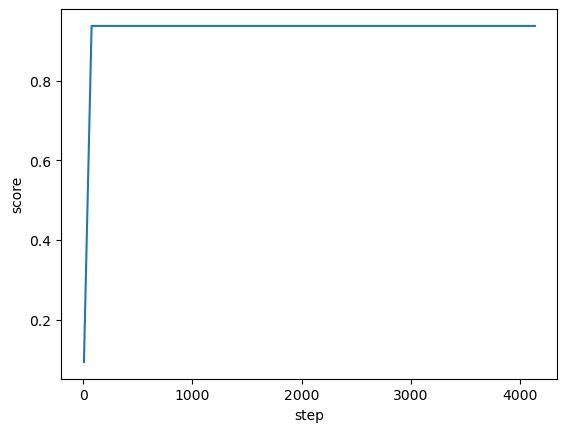

In [6]:
df = pd.read_csv('logs/inference-uniform-DDQN-Minigrid47.csv')
sns.lineplot(data=df, x='step',y='score')

In [7]:
class Qnet(nn.Module):
    def __init__(self, n_input_channels, n_actions):
        super(Qnet, self).__init__()
        self.conv1 = nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.mlp1 = nn.Linear(1024, 512)
        self.mlp2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.mlp1(x))
        x = self.mlp2(x)
        return x

    def sample_action(self, obs, epsilon):
        obs = (torch.tensor(obs).permute(2, 0, 1) / 255.0).unsqueeze(0).to(device)
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 5)
        else:
            return out.argmax().item()

# Convert image to greyscale, resize and normalise pixels
def preprocess(image, history):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(image.shape)
    # image = np.expand_dims(image, axis=2)
    # stack images
    history.popleft()
    history.append(image)
    image = np.concatenate(list(history), axis=1)
    return image

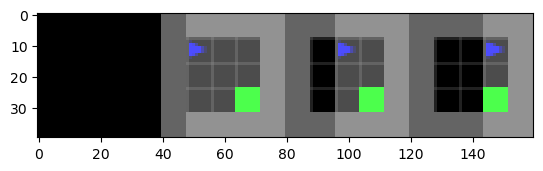

In [21]:
env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")
env = RGBImgObsWrapper(env)  # Get pixel observations

observation, info = env.reset()

# preprocess
img1 = np.zeros((40, 40, 3)).astype(np.uint8)
img2 = np.zeros((40, 40, 3)).astype(np.uint8)
img3 = np.zeros((40, 40, 3)).astype(np.uint8)
img4 = np.zeros((40, 40, 3)).astype(np.uint8)
history = deque([img1, img2, img3, img4])
observation = preprocess(observation["image"], history)
plt.imshow(observation)

observation_prime, reward, terminated, truncated, info = env.step(2)
observation_prime = preprocess(observation_prime["image"], history)
plt.imshow(observation_prime)

observation_prime, reward, terminated, truncated, info = env.step(2)
observation_prime = preprocess(observation_prime["image"], history)
plt.imshow(observation_prime)

observation_prime = (torch.tensor(observation_prime).permute(2, 0, 1) / 255.0).unsqueeze(0).to(device)

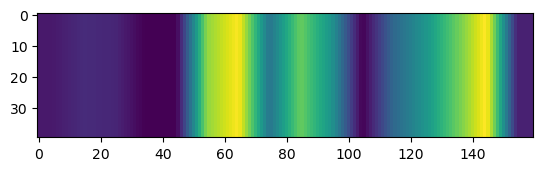

In [30]:
model = Qnet(3,6).to(device)
model.load_state_dict(torch.load('q-model-rgb.pth'))
target_layers = [model.conv3]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=observation_prime, targets=targets)

plt.imshow(np.transpose(grayscale_cam, (1,2,0)))

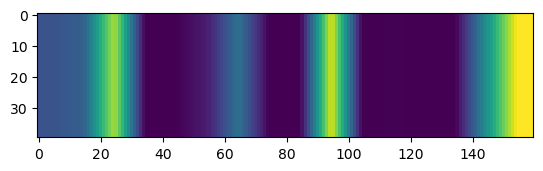

In [31]:
model = Qnet(3,6).to(device)
model.load_state_dict(torch.load('q-model-rgb.pth'))
target_layers = [model.conv3]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=observation_prime, targets=targets)

plt.imshow(np.transpose(grayscale_cam, (1,2,0)))

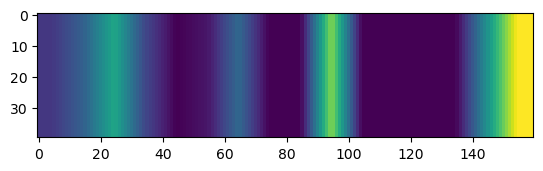

In [32]:
model = Qnet(3,6).to(device)
model.load_state_dict(torch.load('q-model-rgb.pth'))
target_layers = [model.conv3]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(2)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=observation_prime, targets=targets)

plt.imshow(np.transpose(grayscale_cam, (1,2,0)))

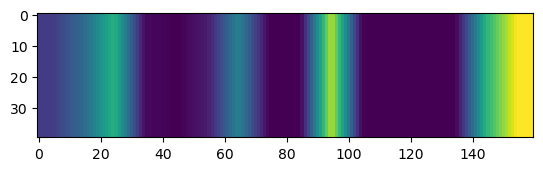

In [33]:
model = Qnet(3,6).to(device)
model.load_state_dict(torch.load('q-model-rgb.pth'))
target_layers = [model.conv3]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(3)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=observation_prime, targets=targets)

plt.imshow(np.transpose(grayscale_cam, (1,2,0)))

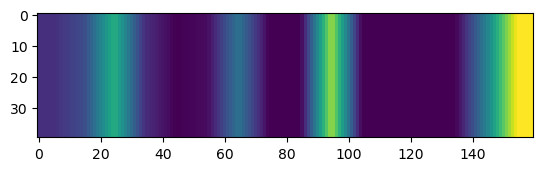

In [34]:
model = Qnet(3,6).to(device)
model.load_state_dict(torch.load('q-model-rgb.pth'))
target_layers = [model.conv3]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(4)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=observation_prime, targets=targets)

plt.imshow(np.transpose(grayscale_cam, (1,2,0)))

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = img

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    # with torch.no_grad():
    #     input_img = inv_normalize(input[0])
    input_img = input
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    print(input_img.detach().cpu().numpy().shape)
    plt.imshow(np.transpose(input_img[0].detach().cpu().numpy(), (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

(1, 3, 40, 160)


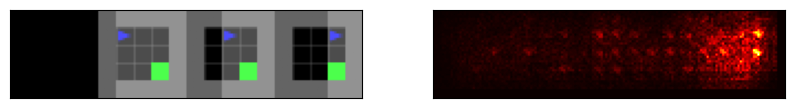

In [76]:
saliency(observation_prime, model)